In [1]:
import numpy as np
import pandas as pd
import scipy.special as special
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi
from scipy.interpolate import interp1d
from datetime import timedelta, datetime, date, time

from astropy.time import Time
from astropy import units as u
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Mars, Sun, Jupiter, Venus
from poliastro.plotting import OrbitPlotter3D, OrbitPlotter2D

import utils.metrics as metrics
from utils.kepler_utils import kepler_numba
import utils.physical_utils as physical_utils
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading
from utils.math_utils import normalize, moving_average, mean_without_k_outlies

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


Using TensorFlow backend.
C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\79105\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (t

In [2]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

df = epr.arg_decomposition_into_sin_cos(df)

real_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
sim_columns = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,a,ecc,inc,raan,argp,nu,error,h,sin_argp,cos_argp
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17,0.000535,26080.000000,-0.866025,-0.500000
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01,0.002533,26686.896582,-0.865923,-0.500177
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,...,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01,0.001743,28338.043990,-0.865882,-0.500249
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,...,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00,0.000915,30651.371610,-0.865941,-0.500147
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,...,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00,0.000948,33244.665434,-0.866014,-0.500020


Описание полей датасета:
- id - integer measurement id
- epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
- sat_id — integer satellite id
- (x, y, z), (x_sim, y_sim, z_sim)	реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) координаты спутника (км)
- реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) скорости спутника (км / с)

In [6]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

print(metrics.smape(satellite_predicted_values, satellite_true_values))
print(metrics.score(satellite_predicted_values, satellite_true_values))

0.15973600741329672
84.02639925867032


## Сопоставление данных из тестовой и обучающей выборок для одного спутника

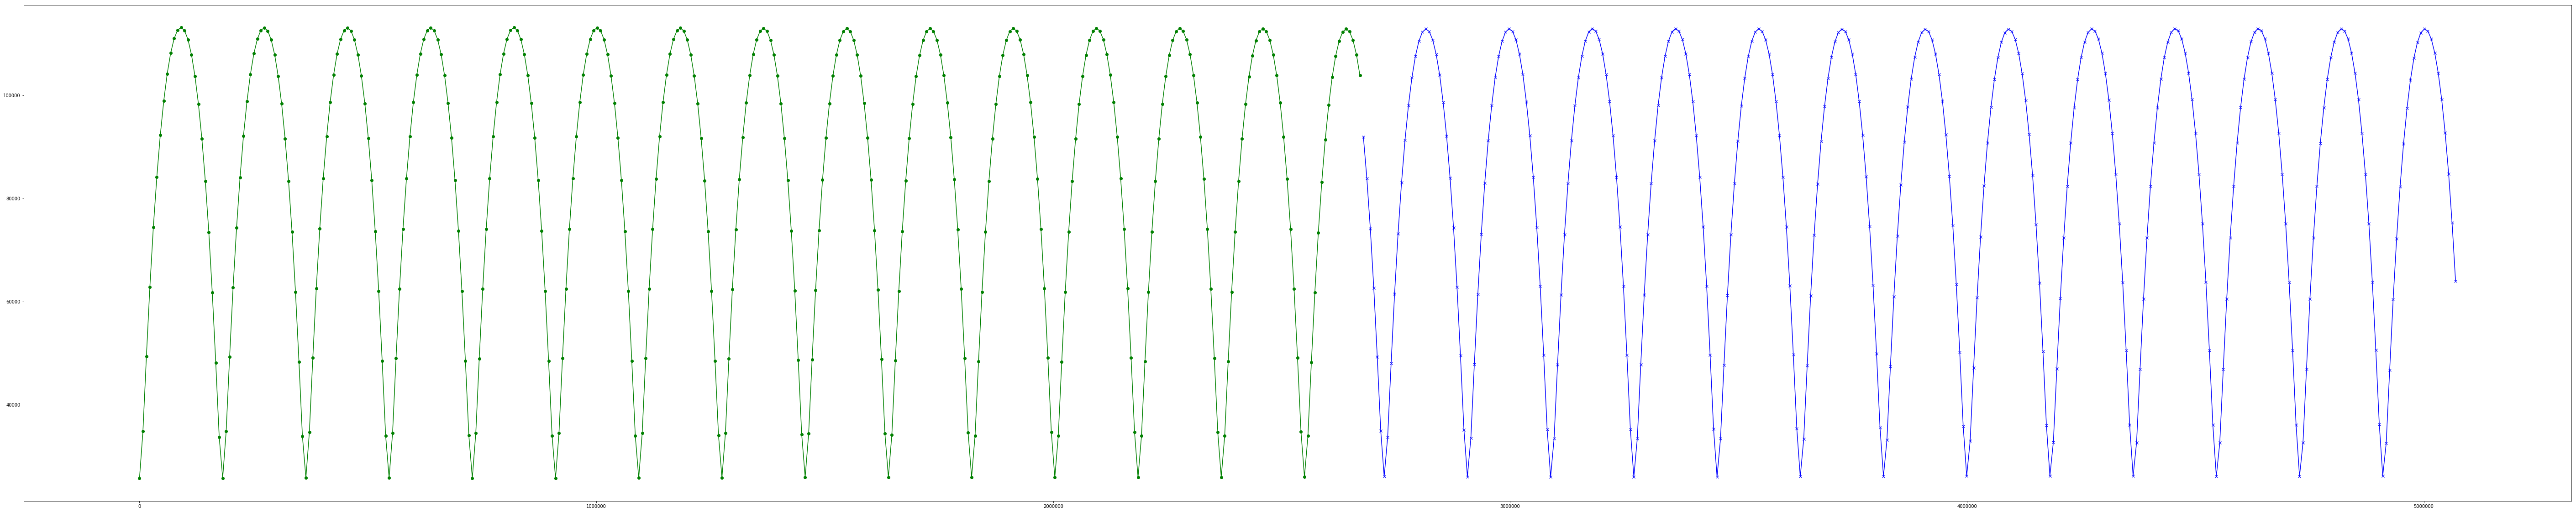

In [7]:
index = 3

plt.figure(figsize = (100, 20))
sat = df[df.sat_id==index]

x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-go')

sat = df_test[df_test.sat_id==index]
x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-bx')

plt.show()

## Визуализация роста ошибки с течением времени

In [8]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

df['error'] = np.mean(np.abs((satellite_predicted_values - satellite_true_values)
                                / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))), axis=1)

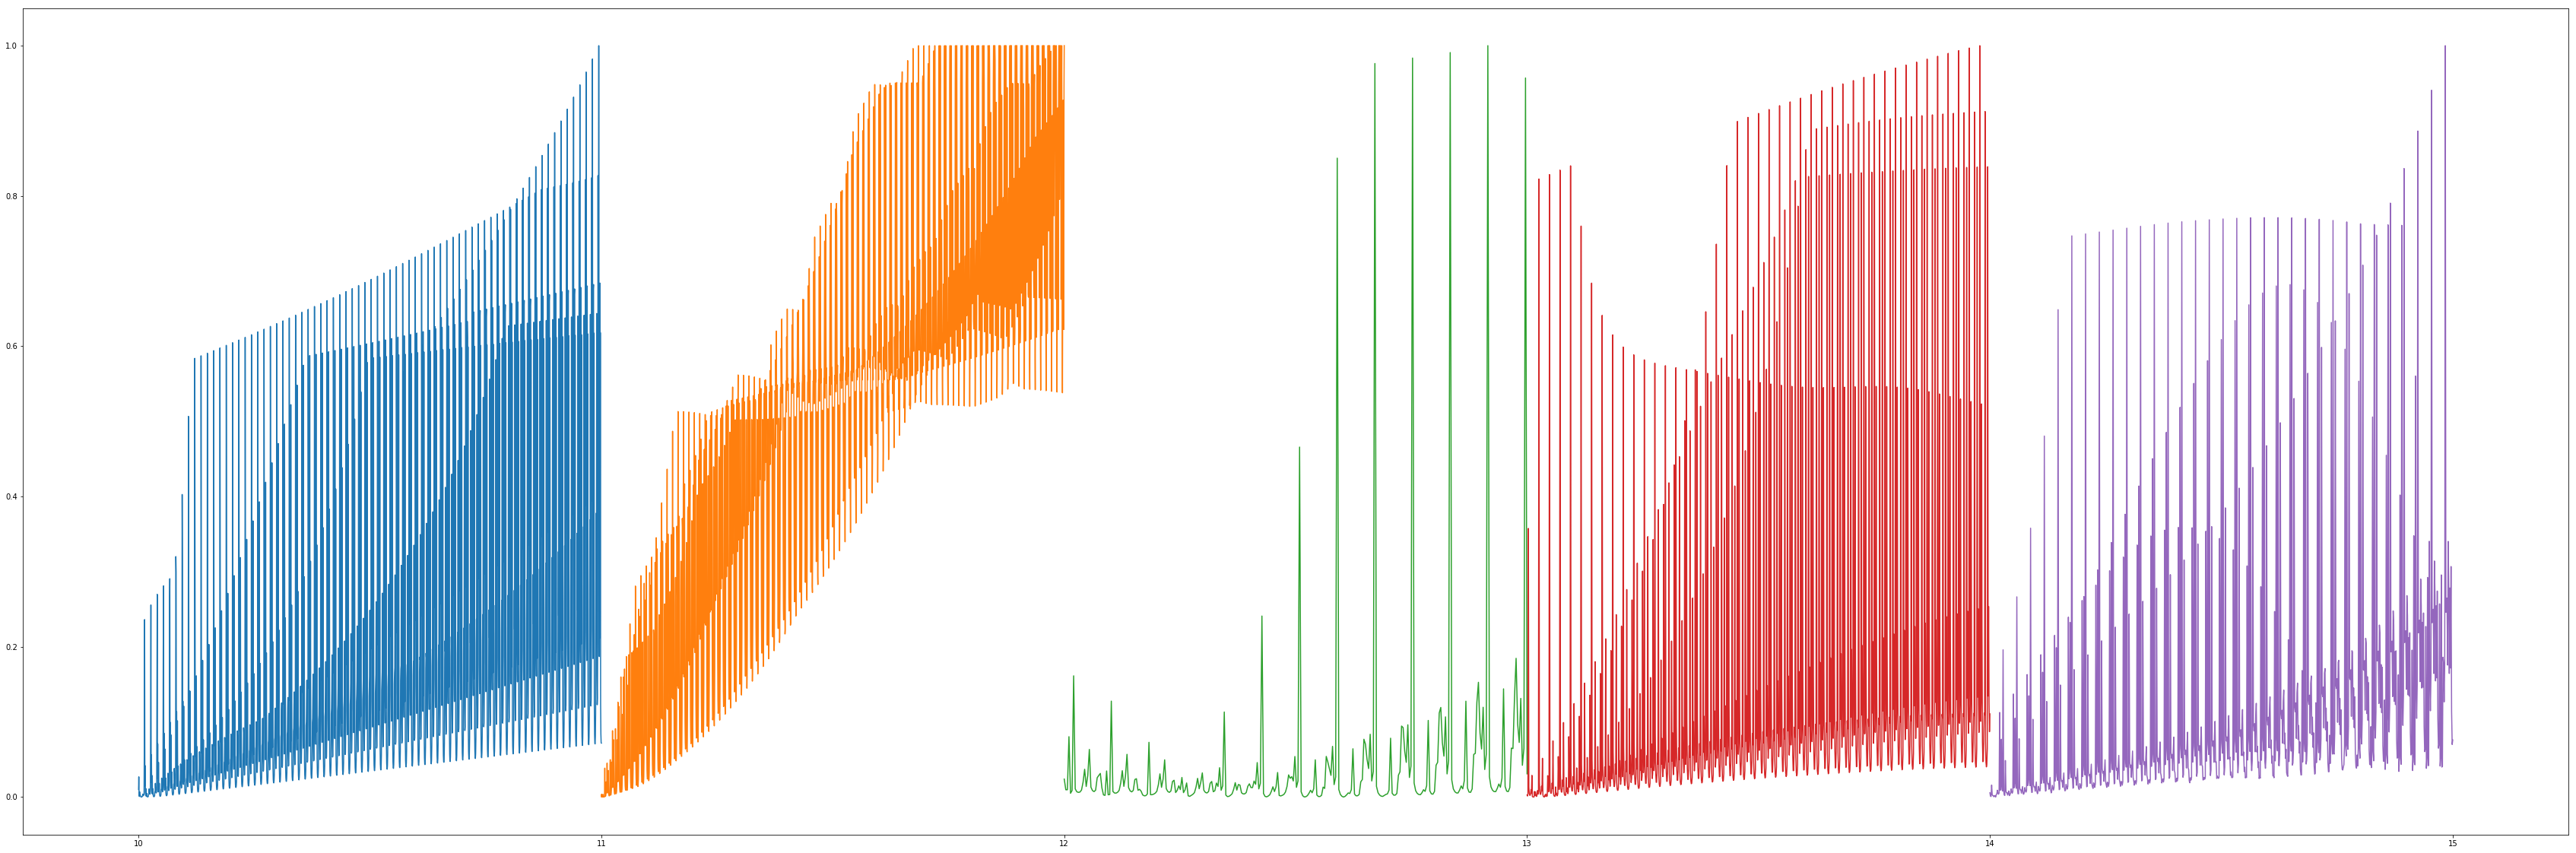

In [9]:
plt.figure(figsize = (60, 20))

for i in range(10,15):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    y=y-y.min()
    y=y/y.max()
    plt.plot(x,y)
    
plt.show()

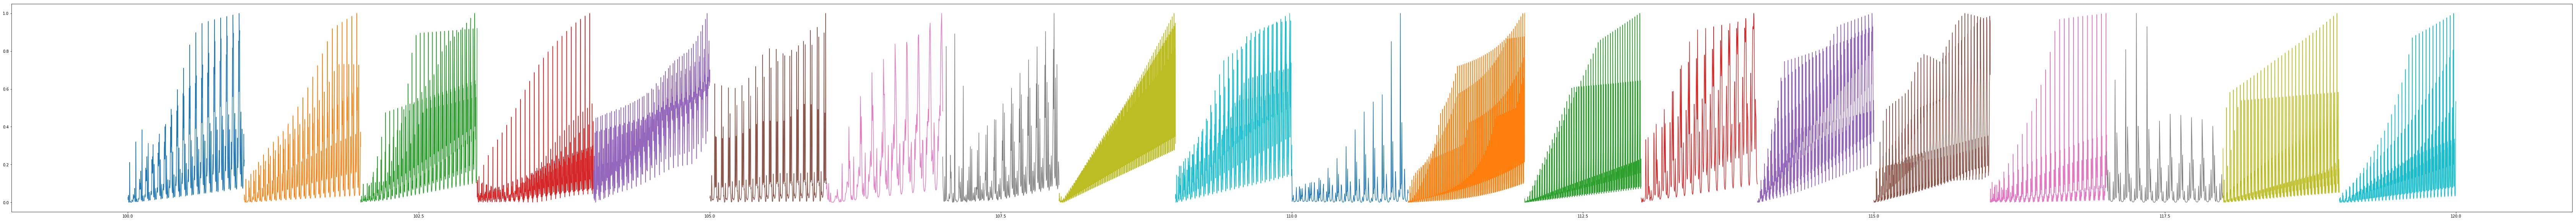

In [10]:
plt.figure(figsize = (120, 10))

for i in range(100,120):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    y=y-y.min()
    y=y/y.max()
    plt.plot(x,y)
    
plt.show()

In [9]:
error_list = []
for i in range(600):
    sat = df[df.sat_id==i]
    error_list.append( [np.sum(sat['error']), len(sat)])
errors = np.array(error_list)

In [28]:
sum(errors[errors[:, 1]>700][:, 0])

94383.26615083154

In [29]:
sum(errors[errors[:, 1]<700][:, 0])

9351.852839481955

## Сопоставление высоты полета спутника и  ошибки

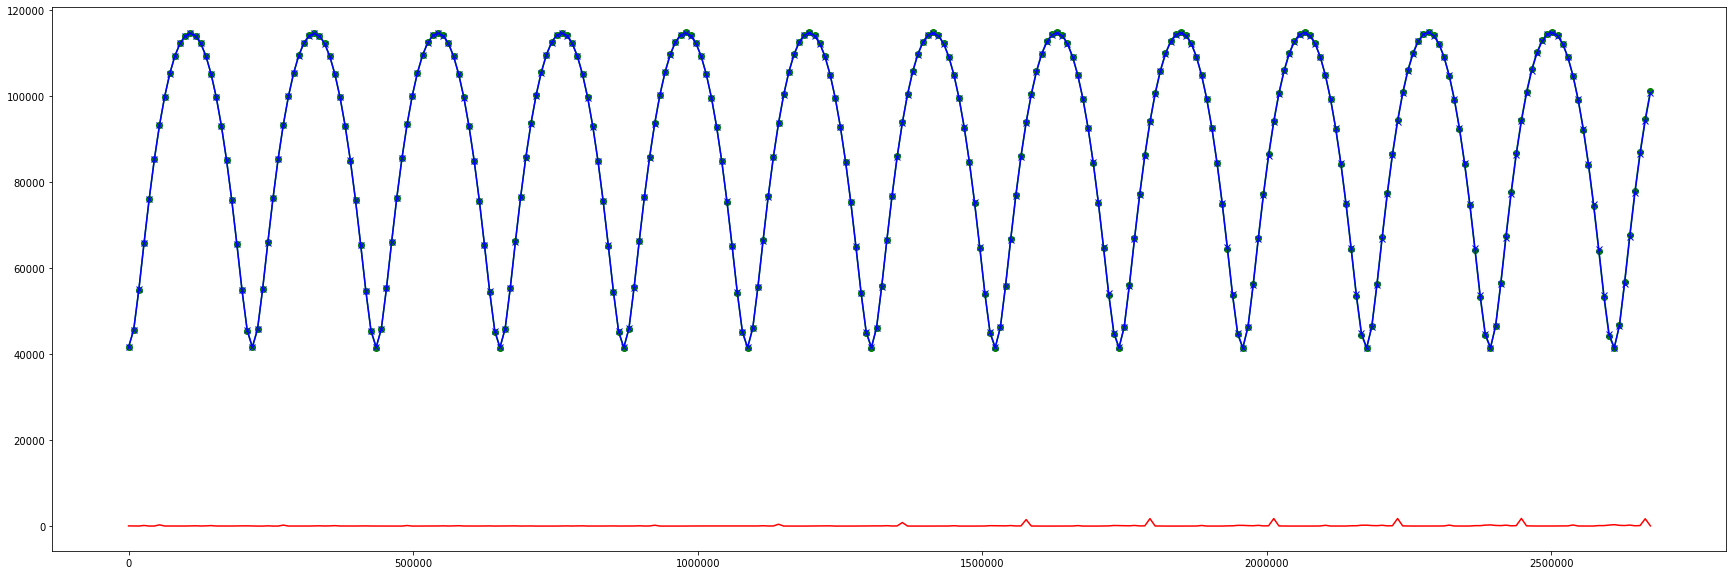

41515.747088490636


In [83]:
plt.figure(figsize = (30, 10))
sat = df[df.sat_id==12]

#x = np.linspace(0.0, 1.0, num=len(sat))
x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

#x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['error']*10000, '-r')

plt.show()
print(y.min())

## Случайно наткнулся на линейную зависимость между средней высотой полета спутника и разбросом его высот, скорее всего это бесполезно для нашей задачи, но я все же хочу изучить этот момент позже

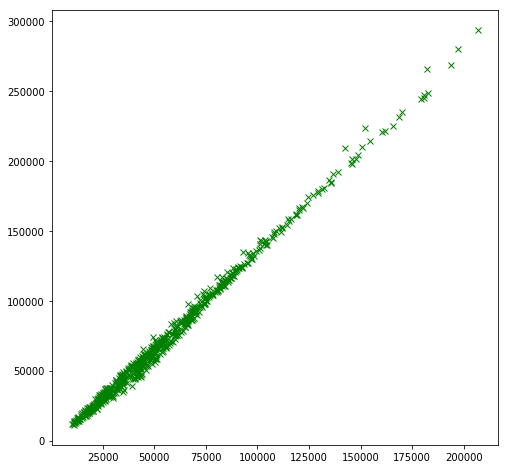

In [11]:
df['h'] = (df.x**2 + df.y**2 + df.z**2)**0.5

h_list = []
y_delta = []

for i in df['sat_id'].unique():
    sat = df[df['sat_id']==i]
    
    h_list.append(np.mean(sat.h))
    y_delta.append(np.max(sat.h))

plt.figure(figsize = (8, 8))

y_delta = np.array(y_delta)
#y_delta=y_delta-y_delta.min()
#y_delta=y_delta/y_delta.max()

plt.plot(h_list,y_delta, 'gx')
    
plt.show()

## Визуализация траектории спутника

In [85]:
df[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']].head()

,a,ecc,inc,raan,argp,nu
0,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17
1,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01
2,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01
3,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00
4,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00


- Большая полуось \(a\).
- Эксцентриситет  \(ecc\).
- Наклонение \(inc\).
- Долгота восходящего узла \(raan\).
- Аргумент перицентра \(argp\)
- Истинная аномалия \(nu\)

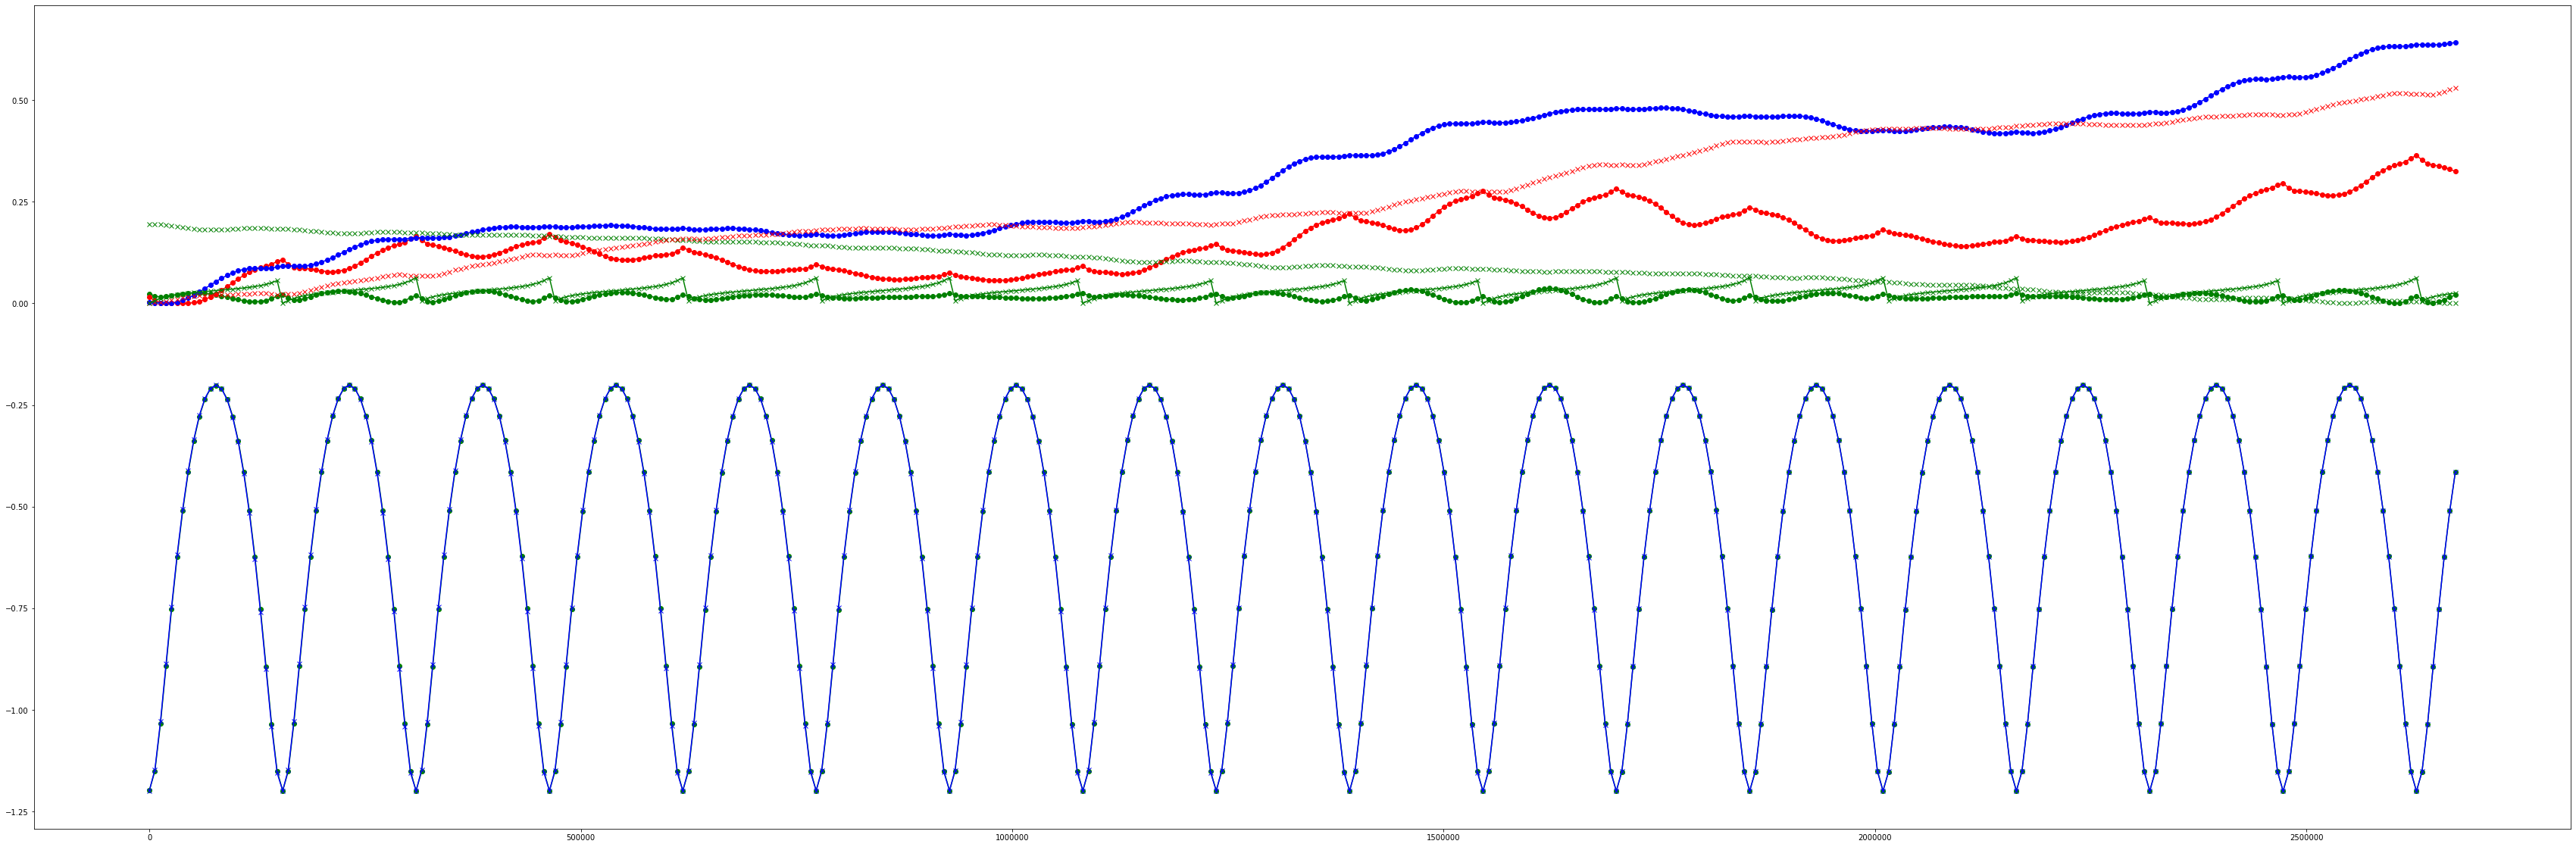

In [190]:
plt.figure(figsize = (60, 20))
sat = df[df.sat_id==2]
k = 100

x = sat['total_seconds']

y = sat['a']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-go')

y = sat['ecc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-ro')

y = sat['inc']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, '-bo')

y = sat['raan']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, 'gx')

y = sat['argp']
y=y/y.mean()-1
y*=k
y=y-y.min()
plt.plot(x,y, 'rx')


y=np.arctan2(np.sin(sat['nu']),np.cos(sat['nu']))
y=np.where(y<0 , 2*np.pi+y, y)/100
plt.plot(x,y, '-gx')



y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-go')

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
y=y-y.min()
y=y/y.max()-1.2
plt.plot(x,y, '-bx')

plt.show()

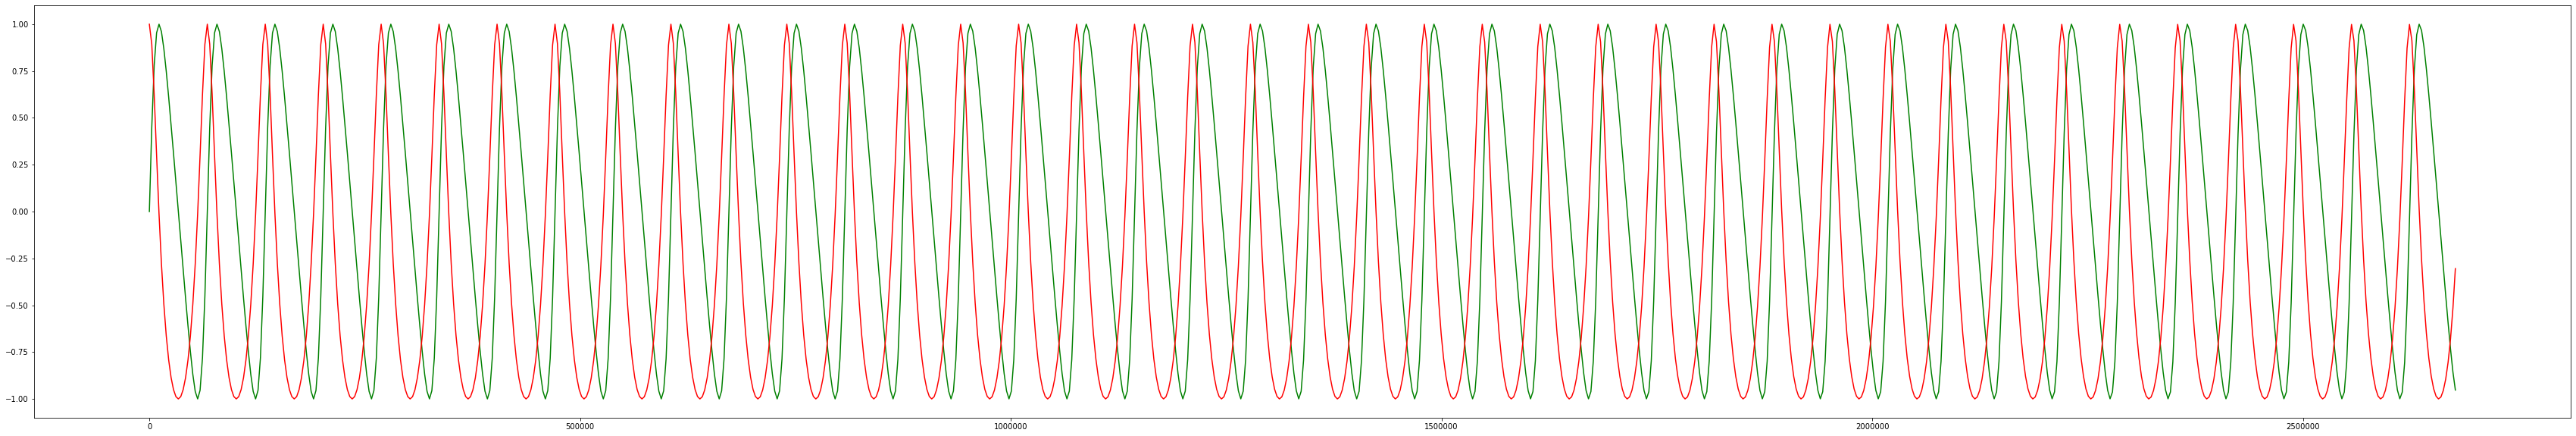

In [289]:
plt.figure(figsize = (60, 10))

y=np.sin(sat['nu'])
plt.plot(x,y, '-g')

y=np.cos(sat['nu'])
plt.plot(x,y, '-r')


plt.show()

# Тест предсказания из последенй позиции

In [345]:
sat.iloc[-1]

4.402940484910361

In [358]:
orbits = []
for i in range(600):
    sat = df[df['sat_id']==i]
    p = np.mean(sat.iloc[-24:][['a', 'ecc', 'inc', 'raan', 'argp', 'nu']], axis=0)
    p['nu'] = sat.iloc[-1]['nu']
    
    sat = sat.iloc[-1]
    
    ss = physical_utils.get_orbit_from_orbital_elements(p[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']], sat['total_seconds'])
    ss = ss.propagate(-sat['total_seconds'] * u.s)
    orbits.append(ss)

In [359]:
df_test = pd.read_csv("data/test.csv")
df_test['epoch'] = df_test.epoch.map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
df_test['total_seconds'] = df_test.epoch.map(lambda x: (x - datetime(2014, 1, 1)).total_seconds())
df_test.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds
0,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,2678505.162
1,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,2679777.007
2,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,2681048.852
3,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,2682320.697
4,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,2683592.542


In [360]:
lambdafunc = lambda r: pd.Series(np.reshape(np.array(orbits[r['sat_id']].propagate(r['total_seconds'] * u.s).rv() ), 6))

df_test[sim_columns] = df_test.apply(lambdafunc, axis=1)

In [361]:
submission = pd.read_csv("data/submission.csv")

submission[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=df_test[sim_columns]
submission.to_csv("data/output_submission.csv",index=False,sep=',')

## Модель для быстрого предсказания

In [86]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

sat = df[df['sat_id']==0]


x = (df[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']] / df[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']].max()).to_numpy()
y = df[['x','y','z']].to_numpy() / 250000

model = Sequential()
model.add(Dense(128, input_dim=6, activation= "relu"))
model.add(Dense(128, activation= "relu"))
model.add(Dense(64, activation= "relu"))
model.add(Dense(3))
model.compile(loss='mean_squared_error' , optimizer="adam", metrics=['accuracy'])

model.fit(x, y, epochs=1, batch_size=16, validation_split=0.1)

## Визуализация изменения параметров орбиты в течении месяца для 300 спутников

- Большая полуось - g.
- Эксцентриситет - r.
- Наклонение - b.
- Долгота восходящего узла - cyan.
- Аргумент перицентра - k.
- Истинная аномалия - y.

In [ ]:
fig, axs = plt.subplots(300, figsize = (30, 900), sharex=True)

for i in range(300):
    sat = df[df.sat_id==i]
    k = 100

    n=len(sat)
    x = np.linspace(0,n,num=n)#sat['total_seconds']

    axs[i].plot(x, normalize(sat['a'], k), 'g')
    axs[i].plot(x,normalize(sat['ecc'], k), 'r')
    axs[i].plot(x, normalize(sat['inc'], k), 'b')
    axs[i].plot(x, normalize(sat['raan'], k), 'cyan')
    axs[i].plot(x,normalize(sat['argp'], k), 'orange')
    axs[i].plot(x,normalize(np.sin(sat['argp']), k), '--')
    axs[i].plot(x,normalize(np.cos(sat['argp']), k), '-.')

    axs[i].set_title('subplot '+str(i))


    y=np.arctan2(np.sin(sat['nu']),np.cos(sat['nu']))
    y=np.where(y<0 , 2*np.pi+y, y)/100
    #axs[i].plot(x,y, 'y--')

plt.show()

## Визуализация изменения периода обращения и элементов орбиты в течении месяца для 300 спутников

In [519]:
def get_ellipse_area(a, e, t0, t1):
    bad_gap = (t1>np.pi) * (t0<np.pi)
    
    b = a*np.sqrt(1-e**2)
    
    E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t0/2))
    E1 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t1/2))
    
    S0 = 0.5 * a * b * (E0-e*np.sin(E0))
    S1 = 0.5 * a * b * (E1-e*np.sin(E1))
    S2 = bad_gap * a*b*np.pi
    
    s = S1 - S0 + S2
    return s# / (a*b*np.pi)

get_ellipse_area(a = 100000, e = 0.3, t0 = 0.0, t1 = 0.4)

992165515.4910176

In [ ]:
fig, axs = plt.subplots(300, figsize = (30, 900), sharex=True)

for i in range(300):
    sat = df[df.sat_id==i]
    
    a = sat[['x', 'y', 'z']].to_numpy()
    b = sat[['x', 'y', 'z']].shift(-1).to_numpy()
    delta_t = np.arccos(np.sum(a * b, axis=1) / (np.sqrt(np.sum(a**2, axis=1)) * np.sqrt(np.sum(b**2, axis=1))))
    sat['delta_t'] = delta_t

    sat['area'] = get_ellipse_area(sat.a, sat.ecc, sat.nu, sat.nu+sat.delta_t)
    y = np.array(sat['area'][:-1])
    y = moving_average(y, n=24)
    x = np.linspace(0,len(y),num=len(y))
    axs[i].plot(x, normalize(y, 5), 'orange')
    

    n=len(sat)
    x = np.linspace(0,n,num=n)#sat['total_seconds']

    axs[i].plot(x, normalize(sat['a'], 1), 'g')
    axs[i].plot(x,normalize(sat['ecc'], 1), 'r')
    axs[i].plot(x, normalize(sat['inc'], 1), 'b')
    axs[i].plot(x, normalize(sat['raan'], 1), 'cyan')

plt.show()

## Наглядный пример, почему важно испльзовать синус/косинус преобразование для некоторых величин

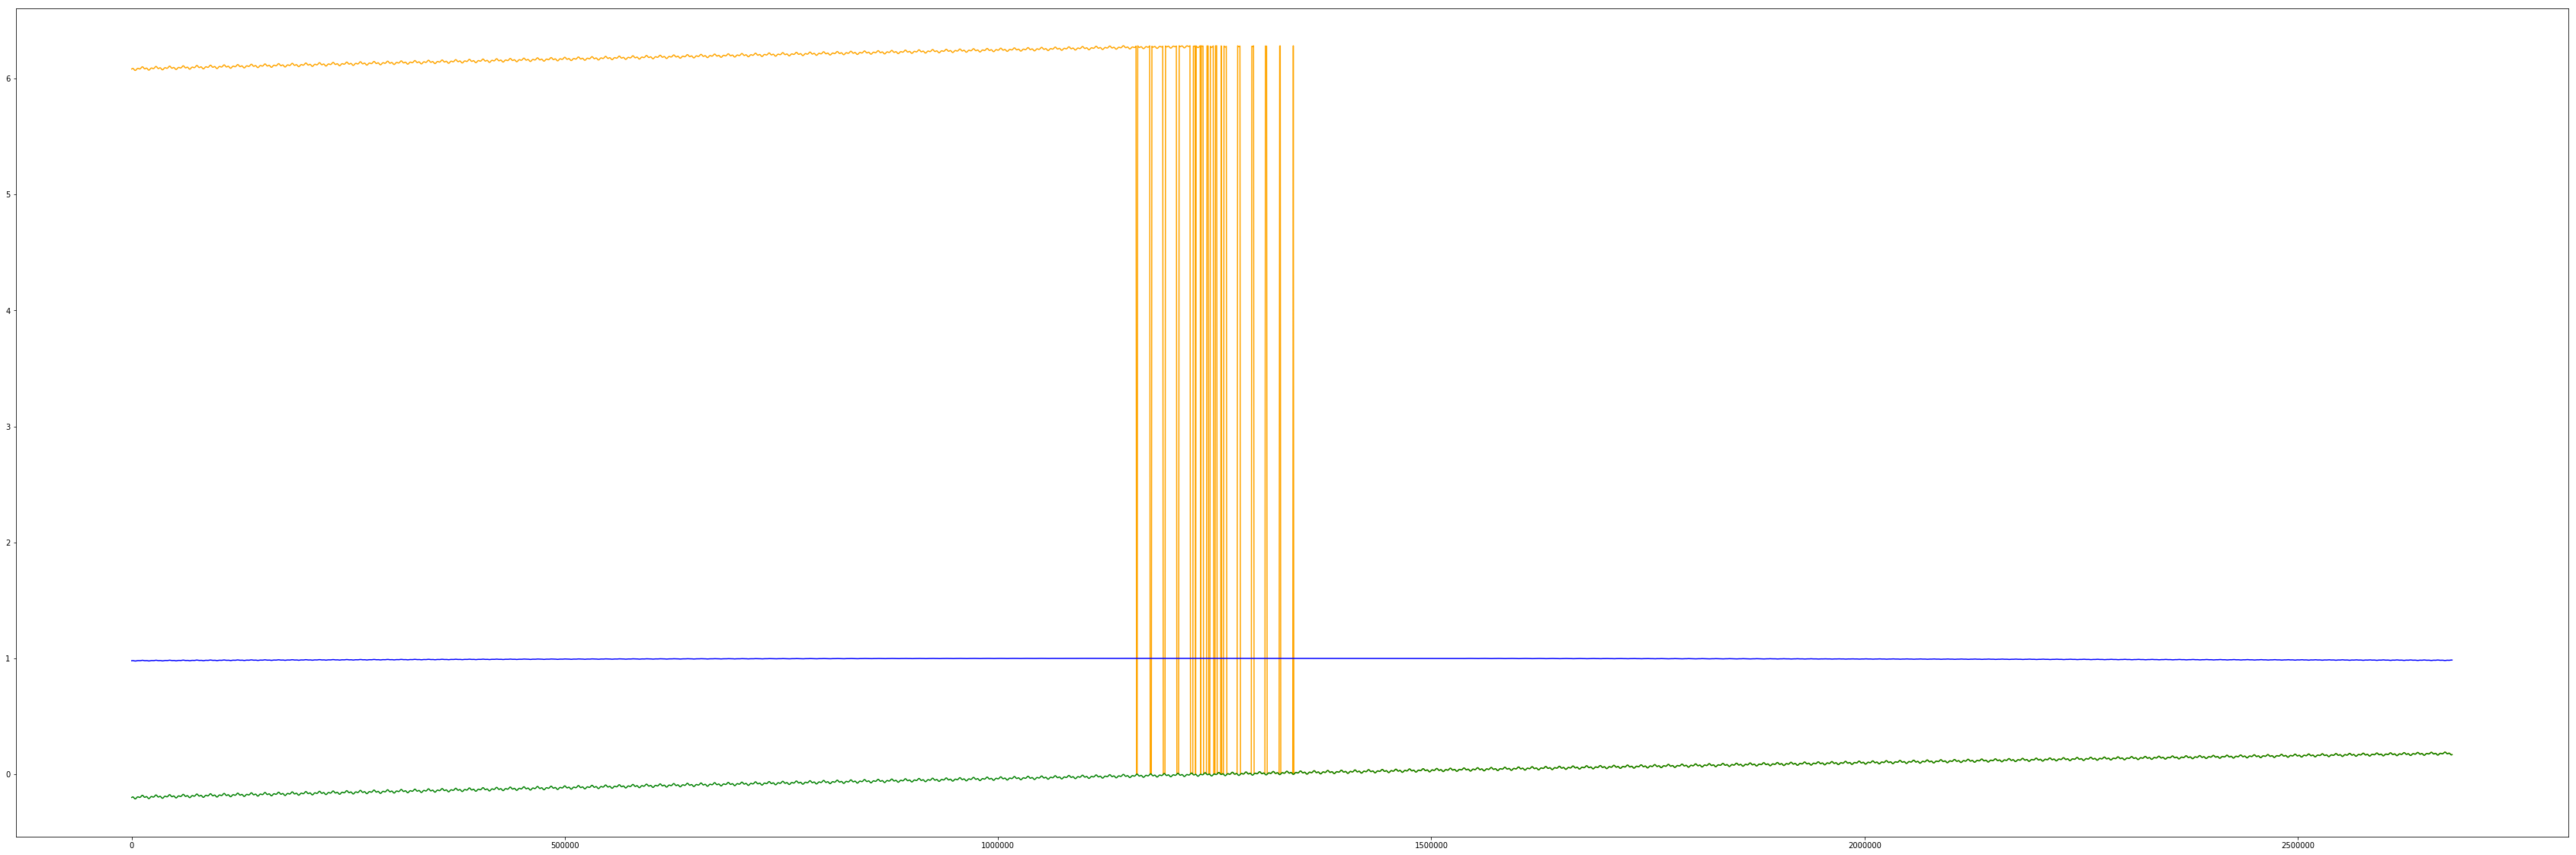

In [29]:
plt.figure(figsize = (60, 20))

sat = df[df.sat_id==295]

x = sat['total_seconds']

plt.plot(x, sat['argp'], 'orange')
plt.plot(x, np.sin(sat['argp']), 'g')
plt.plot(x, np.cos(sat['argp']), 'b')

plt.show()

In [35]:
df['sin_argp'] = np.sin(df['argp'])
df['cos_argp'] = np.cos(df['argp'])

In [36]:
df

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,a,ecc,inc,raan,argp,nu,error,h,sin_argp,cos_argp
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17,0.000535,26080.000000,-0.866025,-0.500000
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01,0.002533,26686.896582,-0.865923,-0.500177
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,...,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01,0.001743,28338.043990,-0.865882,-0.500249
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,...,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00,0.000915,30651.371610,-0.865941,-0.500147
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,...,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00,0.000948,33244.665434,-0.866014,-0.500020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649411,1234089,2014-01-31 22:00:22.601999872,599,-21721.485878,-14048.557595,5277.807430,-1.351754,3.373418,0.004995,-20717.958996,...,23463.568356,0.224351,2.936368,5.086902,3.715058,3.943424e+00,0.185582,26401.518338,-0.542546,-0.840026
649412,1234090,2014-01-31 22:25:13.240000000,599,-23176.890569,-8712.016936,5153.371350,-0.575955,3.764450,-0.175109,-22673.444496,...,23463.785307,0.224364,2.936368,5.086947,3.715042,4.153630e+00,0.119848,25290.803305,-0.542533,-0.840034
649413,1234091,2014-01-31 22:50:03.878000128,599,-23363.044794,-2906.071320,4747.247386,0.351381,3.992943,-0.372198,-23461.830699,...,23464.087189,0.224382,2.936367,5.086999,3.715036,4.384752e+00,0.247846,24016.941319,-0.542528,-0.840038
649414,1234092,2014-01-31 23:14:54.515000064,599,-22058.020262,3074.894039,4038.853542,1.421085,3.984793,-0.578849,-22858.679929,...,23464.495405,0.224408,2.936363,5.087053,3.715043,4.643089e+00,0.191687,22634.565805,-0.542534,-0.840034


## Предсказание элементов кеплера

In [53]:
import keras as K
from keras import backend as backend
from keras.models import Model, Sequential
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Input, Dense, Concatenate, Activation

from scipy.interpolate import interp1d


def sin_activation(x):
    return backend.sin(x)

def square_activation(x):
    return backend.pow(x, 2)

get_custom_objects().update({'sin_activation': Activation(sin_activation)})
get_custom_objects().update({'square_activation': Activation(square_activation)})

In [7]:
sat = df[df.sat_id==3]

y = sat['ecc'].to_numpy()
y = np.mean(y[:len(y)//24*24].reshape(-1, 24), axis=1)
y -= y.min()
y /= y.max()

x = sat['total_seconds'].to_numpy()
x = np.mean(x[:len(x)//24*24].reshape(-1, 24), axis=1)#.reshape(-1, 1)
x -= x.min()
x /= x.max()


f = interp1d(x, y, kind='cubic')
x = np.linspace(0, 1, len(x)*6)
y = f(x)

In [63]:
import keras as K

model = Sequential()

inputs = Input(shape=(1,), name='Input')

#output_1 = Dense(2, activation=Activation(sin_activation), name='SinDense')(inputs)
output_2 = Dense(2, activation=Activation(square_activation), name='SquareDense')(inputs)
output_3 = Dense(2, activation='linear', name='ReluDense')(inputs)

concatenate = K.layers.concatenate([output_2, output_3], axis=1, name='Concatenate')
predictions = Dense(1, activation='linear', name='Predictions')(concatenate)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error', optimizer=K.optimizers.Adam(lr=0.001))
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
SquareDense (Dense)             (None, 2)            4           Input[0][0]                      
__________________________________________________________________________________________________
ReluDense (Dense)               (None, 2)            4           Input[0][0]                      
__________________________________________________________________________________________________
Concatenate (Concatenate)       (None, 4)            0           SquareDense[0][0]                
                                                                 ReluDense[0][0]                  
__________

C:\Users\79105\Anaconda3\envs\IDAO\lib\site-packages\keras\activations.py:211: UserWarning:

Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.



In [66]:
model.fit(x, y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 0s - loss: 0.0570
Epoch 2/10
 - 0s - loss: 0.0515
Epoch 3/10
 - 0s - loss: 0.0464
Epoch 4/10
 - 0s - loss: 0.0432
Epoch 5/10
 - 0s - loss: 0.0398
Epoch 6/10
 - 0s - loss: 0.0382
Epoch 7/10
 - 0s - loss: 0.0376
Epoch 8/10
 - 0s - loss: 0.0365
Epoch 9/10
 - 0s - loss: 0.0364
Epoch 10/10
 - 0s - loss: 0.0359


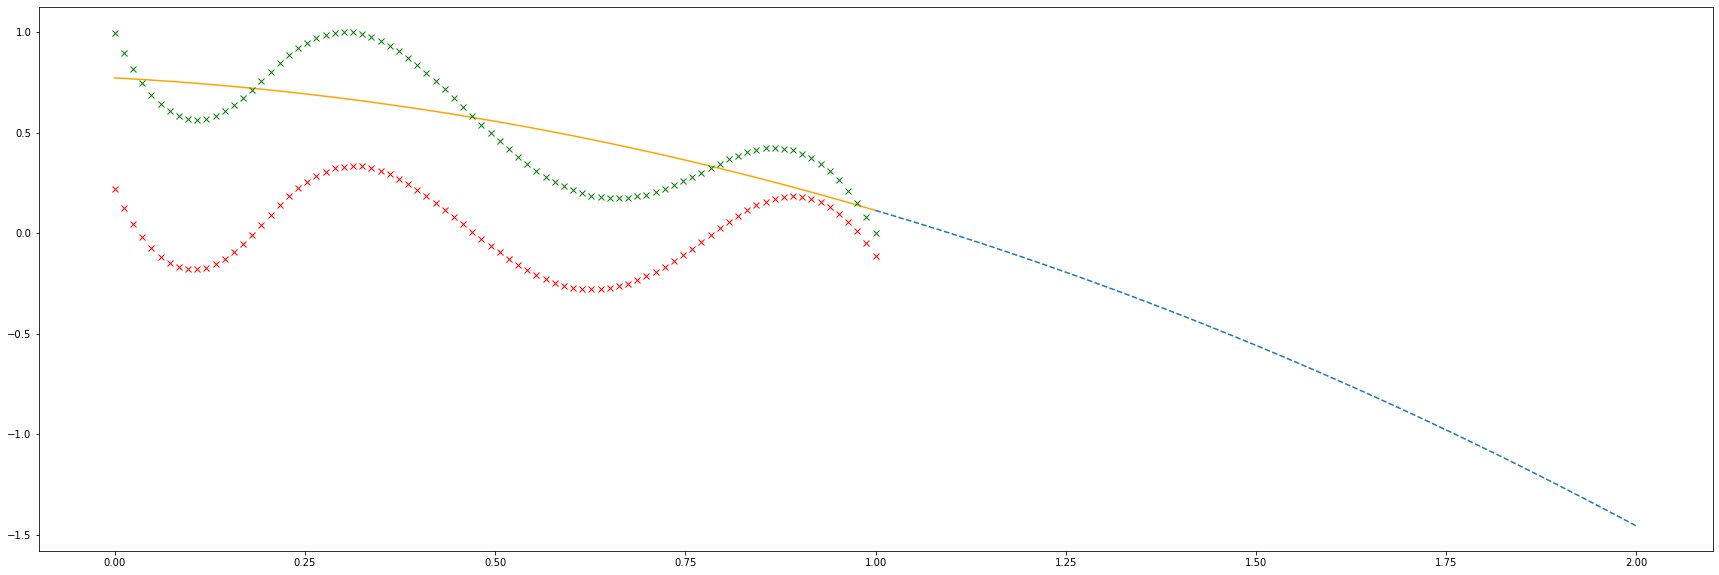

In [69]:
plt.figure(figsize = (30, 10))


plt.plot(x, model.predict(x).reshape(-1), 'orange')
plt.plot(x+x.max(), model.predict(x+x.max()), '--')
plt.plot(x, y, 'gx')
plt.plot(x, y-model.predict(x).reshape(-1), 'rx')

plt.show()

## Тест смещения argp

In [88]:
new_argp = 14

sat = df[(df['ecc']>0.5) & (df['nu']>0.9) & (df['nu']<2) & (df['argp']>0.2) & (df['argp']<0.5)].iloc[0]

p1 = sat[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']]
p1['argp'] = new_argp

p2 = sat[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']]
p2['nu'] = p['nu'] + p['argp']-new_argp
p2['argp'] = new_argp

In [89]:
df['nu+argp'] = df['nu'] + df['argp']

In [90]:
ss = physical_utils.get_orbit_from_orbital_elements(sat[['a', 'ecc', 'inc', 'raan', 'argp', 'nu']], sat['total_seconds'])
ss1 = physical_utils.get_orbit_from_orbital_elements(p1, sat['total_seconds'])
ss2 = physical_utils.get_orbit_from_orbital_elements(p2, sat['total_seconds'])

In [91]:
frame = OrbitPlotter3D()

frame.plot(ss)
frame.plot(ss1)
frame.plot(ss2)

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'dash', 'width': 5},
             …

# Python + numba

In [108]:
df_test = pd.read_csv("data/test.csv")
df_test['epoch'] = df_test.epoch.map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
df_test['total_seconds'] = df_test.epoch.map(lambda x: (x - datetime(2014, 1, 1)).total_seconds())
df_test.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds
0,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,2678505.162
1,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,2679777.007
2,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,2681048.852
3,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,2682320.697
4,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,2683592.542


In [109]:
quick_predictions=[]

for sat_id in df_test['sat_id'].unique():
    sat = df[df['sat_id']==sat_id]
    
    r1 = sat.iloc[-1][['x', 'y', 'z']].to_numpy().astype('float64')
    v1 = sat.iloc[-1][['Vx', 'Vy', 'Vz']].to_numpy().astype('float64')
    total_seconds = sat.iloc[-1]['total_seconds']
    
    sat = df_test[df_test['sat_id']==sat_id]
    
    quick_predictions.append(np.array(sat['total_seconds'].map(
        lambda t: kepler_numba(r1, v1, t-total_seconds, numiter=30000, rtol=1e-9)).to_list()))

quick_predictions = pd.DataFrame(np.concatenate(quick_predictions, axis=0), columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])

In [79]:
submission = pd.read_csv("data/submission.csv")

submission[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=quick_predictions
submission.to_csv("data/output_submission.csv",index=False,sep=',')

In [107]:
sat = df[df['sat_id']==sat_id]
np.array(sat.iloc[-1][['x', 'y', 'z']])

array([41122.54537498, 37965.96820533, -6127.74194152])